In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Create data sets for comaprison
from ipynb.fs.defs.datasets import N_DIM, N_POINTS, default_sets

BLOCKS = [5, 5]

N_DIM = np.sum(BLOCKS)

datasets = default_sets(N_DIM, type="diagblock", blocks=BLOCKS)

dname = "projected-inflated"

2


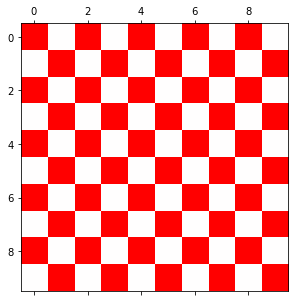

In [3]:
# Projetion onto subspace

A = np.array(
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, -1, 1, -1, 1, -1, 1, -1, 1, -1],
    ],
    dtype=float,
)

K_DIM = len(A)
print(K_DIM)
A = A / np.sqrt(np.sum(A**2, axis=1, keepdims=True))
A = A.T

Q = np.linalg.inv(A.T @ A) @ A.T
P = A @ Q
vm = np.max(np.abs(P))
plt.matshow(P, vmax=vm, vmin=-vm, cmap="bwr")

In [4]:
p_datasets = {}
for name, data in datasets.items():
    p_datasets[name] = (Q @ data.T).T
del datasets

[2. 0. 2. 0. 2. 0. 2. 0. 2. 0.]
3 0.0026997960632601883 11.82915808190081 1.5192273150369584 1.2325693956272639


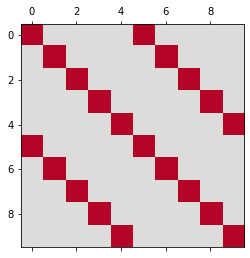

In [5]:
# Get distance function and expected distribution
from ipynb.fs.defs.covfit import fill_max_correlation, inflated, naive
from scipy.stats import chi2

expected = chi2(df=K_DIM)

# Choose actual covariance as "worst"
cov_worst = np.block([[np.eye(5)] * 2] * 2)

# Projected
cov_worst_p = Q @ cov_worst @ Q.T

vm = np.nanmax(np.abs(cov_worst))
plt.matshow(cov_worst, vmin=-vm, vmax=vm, cmap="coolwarm")
print(np.linalg.eig(cov_worst)[0])

# Get worst case distances
data_worst = np.random.default_rng().multivariate_normal(
    mean=np.zeros(K_DIM), cov=cov_worst_p, size=N_POINTS * 4
)
dist_worst = naive(data_worst)


# Try to be conservative up to N sigma effects
sigma_crit = 3
p_crit = chi2.sf(sigma_crit**2, df=1)
x_crit_worst = np.quantile(dist_worst, 1.0 - p_crit)
x_crit_prime = chi2.isf(p_crit, df=K_DIM)
alpha = x_crit_worst / x_crit_prime
# alpha = 1.
print(sigma_crit, p_crit, x_crit_prime, alpha, np.sqrt(alpha))

del data_worst

dist = lambda x: inflated(x, alpha=alpha)

In [6]:
# Compute distances
distances = {}
for name, data in p_datasets.items():
    distances[name] = dist(data)

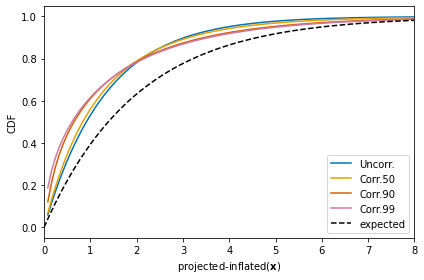

In [7]:
# Compare cumulative distributions
fig, ax = plt.subplots()
x = np.linspace(0, expected.mean() + expected.std() * 3, 100)
for name in distances:
    tot = len(distances[name])
    count, bins = np.histogram(distances[name], bins=x)
    cdf = np.cumsum(count) / tot
    ax.plot(x[1:], cdf, label=name)
ax.plot(x, expected.cdf(x), label=f"expected", linestyle="dashed")
# ax.plot(
#    x,
#    chi2(df=1).cdf(x / N_DIM * alpha),
#    label=rf"$\chi^2_1 \times {N_DIM} / {alpha:0.1f}$",
#    linestyle="dotted",
#    color="0.3",
# )
ax.set_xlim(0, expected.mean() + expected.std() * 3)
ax.set_xlabel(f"{dname}$(\mathbf{{x}})$")
ax.set_ylabel("CDF")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f"plots/{dname}_cdf.pdf")

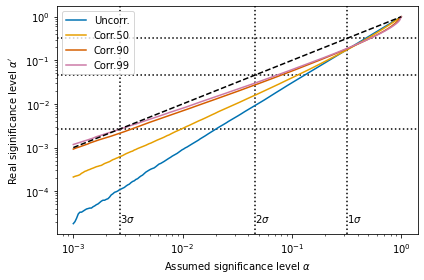

In [8]:
# siginifcance levels
fig, ax = plt.subplots()
for s in [1, 2, 3]:
    SL = chi2.sf(s**2, df=1)
    ax.axhline(SL, color="k", linestyle="dotted")
    ax.axvline(SL, color="k", linestyle="dotted")
    ax.annotate(f"${s}\sigma $ ", (SL, 0.05), xycoords=("data", "axes fraction"))

x = np.logspace(-3, 0, 200)
for name, data in distances.items():
    y = np.sum(data[:, np.newaxis] >= expected.isf(x), axis=0) / len(data)
    ax.plot(x, y, label=name)
ax.plot([1e-3, 1], [1e-3, 1], color="k", linestyle="dashed")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"Real siginificance level $\alpha'$")
ax.set_xlabel(r"Assumed significance level $\alpha$")
ax.legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"plots/{dname}_significance.pdf")

In [9]:
del distances
del data
del p_datasets